# 5.0 - SOTA evaluation

Although we were given a dataset corresponding to [this paper](https://aclanthology.org/2021.emnlp-main.629/). There is a continuation of the work of this team [here](https://aclanthology.org/2022.acl-long.469) where they introduce `bart-base-detox` model for detoxification. In the paper they conclude that it is a new SOTA.

I will evaluate on the same input data model of their team for further comparison in report.


In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text2text-generation", model="s-nlp/bart-base-detox")

/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model to evaluate toxicity

In [2]:
from transformers import pipeline

# load metrics
import evaluate

# Load the BLUE metric
metric = evaluate.load("sacrebleu")

# load toxicity rate metric
toxicity_rater = pipeline("text-classification", model="martin-ha/toxic-comment-model")

## Load dataset for evaluation

In [3]:
import pandas as pd

# load validation dataset
df = pd.read_csv("../data/interim/val_subset.csv", index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
Unnamed: 0,,,,,,
314081,But the French will hog them all.,but I guess the French will eat them.,0.640306,0.105263,0.930104,0.001689
284848,Gay? Oh! I can't even say it.,I can't even say.,0.680517,0.400000,0.982420,0.000055
148298,"He come round at night, kicked my door in, dra...","he came out that night, knocked out the door, ...",0.730038,0.243697,0.995085,0.002226
211184,Of course he rolled his fucking eyes!,that's why he rolled his eyes.,0.710801,0.184211,0.998498,0.000072
14849,I'm the fucking customer here!,I'm your customer!,0.845089,0.387097,0.995472,0.000044


In [4]:
def evaluate(sentence):
    """
    evaluate is a helper function which computes bleu score and toxicity rate
    after sentence transformation
    """
    result = pipe(sentence)[0]["generated_text"]

    # compute bleu score
    bleu_score = metric.compute(predictions=[result], references=[sentence])["score"]

    # compute toxicity rate
    toxicity = toxicity_rater(result)[0]

    return {
        "sentence": result,
        "bleu_score": bleu_score,
        # "toxicity": toxicity,
        "rate": toxicity["score"] * (-1 if toxicity["label"] == "toxic" else 1),
    }


evaluate("I bet it's bullshit favorite secret jerk-off movie.")

/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'sentence': "I bet it's favorite secret movie",
 'bleu_score': 24.117803988461304,
 'rate': 0.9988685846328735}

In [6]:
from tqdm import tqdm

history = []

for sentence in tqdm(df["reference"]):
    history.append(evaluate(sentence))

  0%|          | 0/500 [00:00<?, ?it/s]/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


In [7]:
# save as pandas dataframe for further comparison
history_df = pd.DataFrame(history)
history_df.to_csv("../data/evaluations/sota.csv", index=False)

history_df.head()

,sentence,bleu_score,rate
0,But the French will hog them all.,100.000000,0.978538
1,Gay? Oh! I can't even say it,89.483932,0.924245
2,"He come round at night, kicked my door in, dra...",48.962043,0.994018
3,Of course he rolled his eyes!,61.297524,0.996968
4,I'm the customer here!,40.936538,0.998950


# Analysis:

Well, SOTA is SOTA and it produces some decent results. The results confirm that it is great for toxicity rate reduction. Moreover, it proves that BLEU score is not representative enough for the quality of the paraphrase.


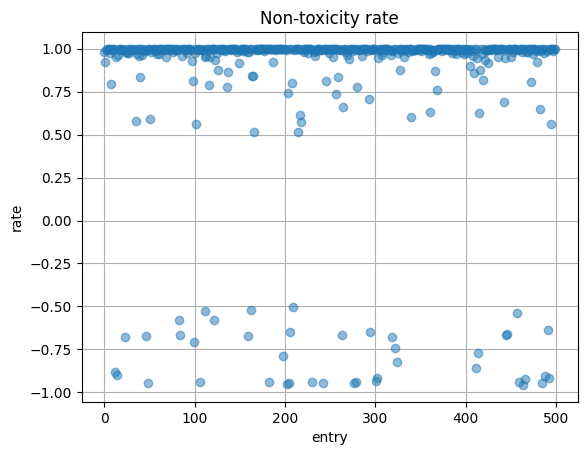

In [8]:
import sys

# to be able to load modules from src
sys.path.append("..")

from src.visualization.utils import simple_hist, simple_plot

simple_plot(
    history_df["rate"],
    title="Non-toxicity rate",
    xlabel="entry",
    ylabel="rate",
    save_path="../reports/figures/sota_rate.png",
    marker="o",
    linestyle="None",
    alpha=0.5,
)

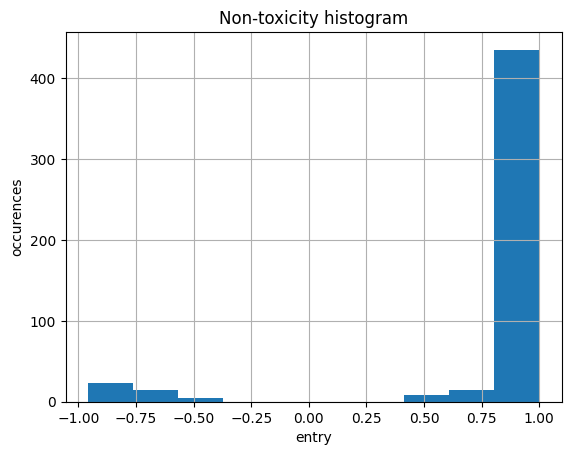

In [9]:
simple_hist(
    history_df["rate"],
    title="Non-toxicity histogram",
    xlabel="entry",
    ylabel="occurences",
    save_path="../reports/figures/sota_rate_hist.png",
)

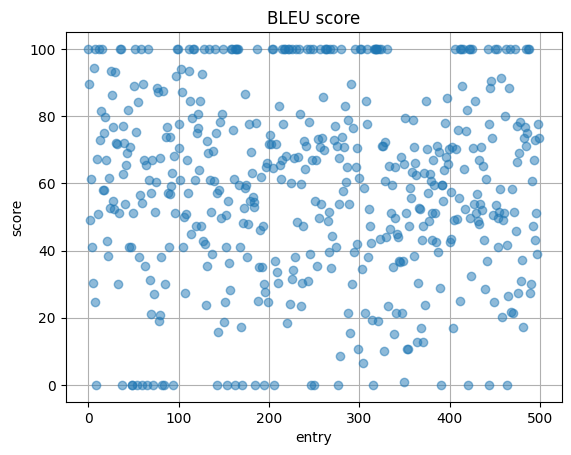

In [10]:
simple_plot(
    history_df["bleu_score"],
    title="BLEU score",
    xlabel="entry",
    ylabel="score",
    save_path="../reports/figures/sota_bleu.png",
    marker="o",
    linestyle="None",
    alpha=0.5,
)

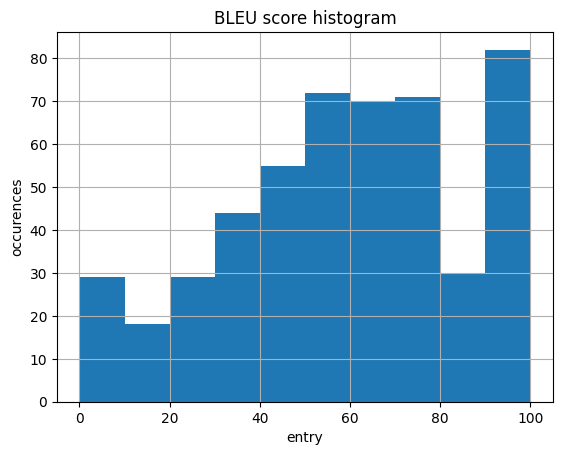

In [11]:
simple_hist(
    history_df["bleu_score"],
    title="BLEU score histogram",
    xlabel="entry",
    ylabel="occurences",
    save_path="../reports/figures/sota_bleu_hist.png",
)